In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from ltcl.datasets.physics_dataset import PhysicsDataset
from ltcl.tools.utils import load_yaml
import torchvision.transforms as transforms
from ltcl.modules.components.beta import BetaVAE_Physics
from ltcl.modules.components.graph import GNNModel
from ltcl.modules.physics_vae import PhysicsVAE
import matplotlib.pyplot as plt
%matplotlib inline

In [217]:
cfg = load_yaml('../ltcl/configs/ball_5_s1.yaml')

trans_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

In [218]:
class Namespace(object):
    def __init__(self, **kwds):
        self.__dict__.update(kwds)
    def __repr__(self):
        items = list(self.__dict__.items())
        temp = []
        for name, value in items:
            if not name.startswith('_'):
                temp.append('%s=%r' % (name, value))
        temp.sort()
        return '%s(%s)' % (self.__class__.__name__, ', '.join(temp))


In [248]:
# Genenrate args
phase = 'raw'
namespace = Namespace()
for k in cfg:
    setattr(namespace, k, cfg[k])

trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.9920, 0.9887, 0.9860), (0.0692, 0.0670, 0.0949))
])
data = PhysicsDataset(namespace, phase=phase, trans_to_tensor=trans_to_tensor)
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [250]:
for batch in train_loader:
    break

In [263]:
model = PhysicsVAE(3,5)

In [279]:
model = model.load_from_checkpoint("/data/datasets/logs/cmu_wyao/try_ball_1_g10_gat/lightning_logs/version_16/checkpoints/epoch=0-step=1553.ckpt",
                                   nc = 3, n_obj=5,z_dim=10, lag=1,hidden_dim=512,num_layers=3)

In [280]:
x_recon, mu, logvar, z = model(batch)

In [281]:
def denormalize(x):
    x = x * torch.tensor([0.0623, 0.0599, 0.0848]).reshape(3,1,1) + torch.tensor([0.9919, 0.9886, 0.9859]).reshape(3,1,1)
    return x

In [282]:
x, kps_gt, graph_gt, actions = batch
# Concatenate x to the shape of x_recon triplets
triples = []
for i in range(4 - 2):
    # pair consecutive frames (n, 2c, w, h)
    triple = torch.stack((x[:, i], x[:, i+1], x[:, i+2]), 1)
    triples.append(triple)
triples = torch.stack(triples, dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


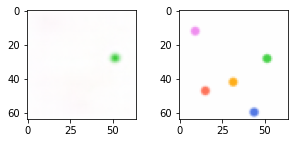

In [285]:
sample_idx = 1
fig, axs = plt.subplots(1,2,figsize=(5,2))
axs[0].imshow(denormalize(x_recon[sample_idx][0][0]).permute(1,2,0).detach().cpu().numpy())
axs[1].imshow(denormalize(triples[sample_idx][0][0]).permute(1,2,0).detach().cpu().numpy())

In [216]:
triples[sample_idx][1][0][2].std()

tensor(1.0024)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


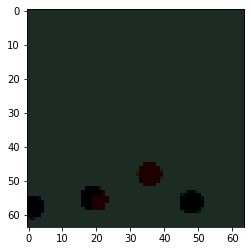

In [260]:
fig = plt.figure(figsize=(2,2))
plt.imshow(triples[sample_idx][0][0].permute(1,2,0).detach().cpu().numpy())

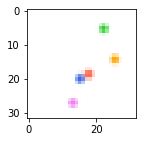

In [175]:
fig = plt.figure(figsize=(2,2))
plt.imshow(denormalize(batch[0][0][0]).permute(1,2,0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


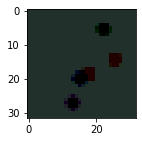

In [122]:
fig = plt.figure(figsize=(2,2))
plt.imshow(batch[0][0,0].permute(1,2,0).detach().cpu().numpy())

In [19]:
batch[0].shape

torch.Size([64, 4, 3, 32, 32])

In [67]:
batch[0][0,2].permute(1,2,0).cpu().numpy().min()

-0.9764706

In [6]:
imgs, kps_gt, graph_gt, actions = datasets.__getitem__(1)

In [121]:
imgs.shape

torch.Size([4, 3, 32, 32])

In [7]:
frames = imgs.unsqueeze(0).expand(16, -1, -1, -1, -1)

In [8]:
model = BetaVAE_Physics()

In [10]:
x_recon, mu, logvar, z = model(frames)

In [122]:
mu.shape

torch.Size([16, 2, 5, 32])

In [11]:
imgs

NameError: name 'imgs' is not defined

In [123]:
import torch

In [31]:
adj = torch.tensor([[0,1,0,1.],
                    [1,0,1,0],
                    [1,1,1,1],
                    [0,0,1,1]], requires_grad=True)

In [32]:
from torch_geometric.utils.sparse import dense_to_sparse

In [35]:
dense_to_sparse(adj)[1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], grad_fn=<IndexBackward>)

In [27]:
adj.nonzero(as_tuple=True)

(tensor([0, 1]), tensor([1, 0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


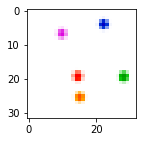

In [12]:
fig = plt.figure(figsize=(2,2))
plt.imshow(imgs[1].permute(1,2,0).cpu().numpy())

In [21]:
batch_size = 8

In [40]:
gnn = GNNModel(32,32,32)
logits = torch.randn(5,5,2)
logits[:,:,1] = logits[:,:,1]-5
logits.requires_grad = True

In [41]:
logits[:,:,0]

tensor([[-1.0178,  1.0590, -0.5325, -0.8734, -0.8832],
        [ 0.9283,  0.4861,  1.0359, -0.2781,  1.2075],
        [ 0.0629,  1.5760,  0.0589,  0.6064, -0.2881],
        [-0.5800,  1.2171,  0.9604,  1.7218, -1.1108],
        [ 0.2490,  2.9146, -0.1687, -0.1517,  0.7424]],
       grad_fn=<SelectBackward>)

In [42]:
logits[:,:,1]

tensor([[-5.7188, -4.3796, -3.9237, -5.8701, -5.3166],
        [-4.6118, -4.9388, -4.5928, -4.7733, -5.9274],
        [-3.7684, -5.9611, -6.0958, -6.0777, -6.4180],
        [-4.9877, -4.5929, -4.7319, -6.6092, -5.7585],
        [-4.0608, -3.7016, -4.3486, -4.8582, -7.2089]],
       grad_fn=<SelectBackward>)

In [45]:
adj = torch.nn.functional.gumbel_softmax(logits, hard=True)[:,:,0].fill_diagonal_(1)
# adj = adj.unsqueeze(0).repeat(batch_size, 1, 1)

In [46]:
adj

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], grad_fn=<AsStridedBackward>)

In [117]:
x = torch.randn(batch_size, 5, 32)

In [118]:
loss  = gnn(x, adj).sum()

In [119]:
grads = loss.backward()

In [120]:
logits.grad[1,1]

tensor([0., 0.])

In [25]:
adj.shape

torch.Size([5, 5])

In [27]:
mask = ~torch.eye(adj.shape[0],dtype=bool)

In [29]:
torch.masked_select(adj, mask)

tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 0.], grad_fn=<MaskedSelectBackward>)